# Chunking and Named Entity Recognition

This notebook provides an introduction on using NLTK for Chunking and Named Entity Recognition

## Initialize NTLK

Download some of the resources that NLTK needs

In [1]:
import nltk
nltk.download('book', quiet=True)

True

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)

## Loading the Data and Working on the Data Representation

A labelled data can be loaded from `nltk` by using the `nltk.corpus.conll2000` module. This provides sentences labeled with the POS tags and the appropriate phrase.

NLTK works with different format for the usecase. It can provide the tree format or the conlltags format. This is important since some NLTK functions and libraries outside NLTK can be used with ease if the appropriate format is used.

### Loading the Data and Sorting by length

The data is sorted by length so an appropriate sample can be used. Sentences with very long lengths are hard to visualize in a notebook environment.

By default, NLTK provides the data in a tree format from the `nltk.corpus.conll2000` module

In [3]:
CONLL_TREES = sorted(nltk.corpus.conll2000.chunked_sents('train.txt'), key=len)

In [4]:
SAMPLE = CONLL_TREES[1000]

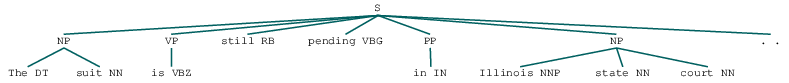

In [5]:
SAMPLE

### Conversion to IOB Tags

A tree can easily be converted by calling the `nltk.chunk.tree2conlltags` function.

In [6]:
SAMPLE_IOB = nltk.chunk.tree2conlltags(SAMPLE)
SAMPLE_IOB

[('The', 'DT', 'B-NP'),
 ('suit', 'NN', 'I-NP'),
 ('is', 'VBZ', 'B-VP'),
 ('still', 'RB', 'O'),
 ('pending', 'VBG', 'O'),
 ('in', 'IN', 'B-PP'),
 ('Illinois', 'NNP', 'B-NP'),
 ('state', 'NN', 'I-NP'),
 ('court', 'NN', 'I-NP'),
 ('.', '.', 'O')]

### Conversion to Tree

To convert the IOB Tags to the tree format, the `nltk.chunk.conlltags2tree` can be used.

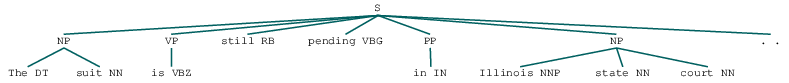

In [7]:
nltk.chunk.conlltags2tree(SAMPLE_IOB)

### Removing the some information

If there is a need to remove information in the IOB data, the data can easily be iterated on as it is just a list of tuple. This is useful for creating training data and for reusing POS taggers for chunking.

In [8]:
SAMPLE_POS = [(w, pos) for w, pos, iob in SAMPLE_IOB]
SAMPLE_POS

[('The', 'DT'),
 ('suit', 'NN'),
 ('is', 'VBZ'),
 ('still', 'RB'),
 ('pending', 'VBG'),
 ('in', 'IN'),
 ('Illinois', 'NNP'),
 ('state', 'NN'),
 ('court', 'NN'),
 ('.', '.')]

## Rule Based Chunking

The `nltk.RegexpParser` can be used to provide a regex rule that will be used to match a phrase label. NLTK also allows the inversion of the patterns to allow chinking

### Chunking Rules

Multiple rules can be defined to assign to a phrase label. These two examples however, can already show how tedious creating rules are for tagging

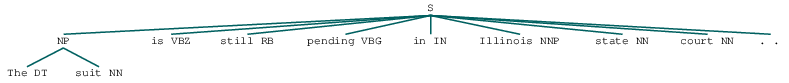

In [9]:
grammar = r"""
    NP: {<DT><NN>}
"""
chunker = nltk.RegexpParser(grammar)
chunker.parse(SAMPLE_POS)

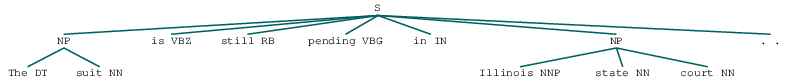

In [10]:
grammar = r"""
    NP: {<DT><NN>}
        {<NNP><NN>+}
"""
chunker = nltk.RegexpParser(grammar)
chunker.parse(SAMPLE_POS)

### Chinking Rules

A chinking rule can be defined by inverting the brackets the surrounds the regular expression.

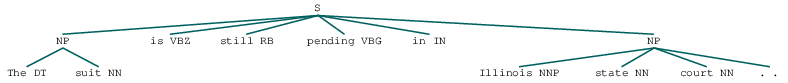

In [11]:
grammar = r"""
    NP: {<.*>+}             # Chunk everything
        }<VBZ|RB|VBG|IN>{   # Remove everything in between
"""
chunker = nltk.RegexpParser(grammar)
chunker.parse(SAMPLE_POS)

## Machine Learning Base Chunking

The N-gram chunkers and CRF chunkers will be utilized in this part to show how data driven models can be created for chunking

### Loading and Splitting the Data

The data is split to train and and test. A validation won't be created since the models won't be optimized here. The goal is to only show how a basic implementation of the algorithms will generalize

*   TRAIN: 80%
*   TEST: 20% 

In [12]:
CONLL2000_DATA = nltk.corpus.conll2000.chunked_sents('train.txt', chunk_types=['NP'])
CONLL2000_TRAIN, CONLL2000_TEST = train_test_split(CONLL2000_DATA, test_size=0.2, random_state=0)
len(CONLL2000_TRAIN), len(CONLL2000_TEST)

(7148, 1788)

### Baseline Models

The performance of a no tag output and a simple rule that labels any sequence of POS tags that starts with D or N as NP are evaluated so have a view on the performance of baseline chunkers

In [13]:
grammar = r""""""
chunker = nltk.RegexpParser(grammar)
print(chunker.evaluate(CONLL2000_TEST))

ChunkParse score:
    IOB Accuracy:  44.1%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


In [14]:
grammar = r"""
    NP: {<[DN].*>+}
"""
chunker = nltk.RegexpParser(grammar)
print(chunker.evaluate(CONLL2000_TEST))

ChunkParse score:
    IOB Accuracy:  73.0%%
    Precision:     50.7%%
    Recall:        48.7%%
    F-Measure:     49.7%%


### Helper Functions

While its easy to work with NLTK provided functionalities, in this part several helper functions are provided to utilize taggers as chunckers and to allow the usage of the data into other machine learning libraries.

*   `to_ngram_fmt`: Converts the data for the use of N-gram taggers as chunkers. Transforms the data to (pos_tags, iob) or pos_tags depending on the label flag.
*   `to_crf_fmt`: Converts the data for the use of CRF tagger as chunkers. Transforms the data to ((word, pos_tags), iob) or (word, pos_tags) depending on the label_flag
*   `to_evaluate`: Takes all of the iob_tags and flattens the resulting array for use of Scikit-Learn metrics functions.

In [15]:
def to_ngram_fmt(data, label=True):
    if label:
        return [
            [(pos, iob) for w, pos, iob in nltk.chunk.tree2conlltags(s)]
            for s in data
        ]
    else:
        return [
            [pos for w, pos, iob in nltk.chunk.tree2conlltags(s)]
            for s in data
        ]

def to_crf_fmt(data, label=True):
    if label:
        return [
            [((w, pos), iob) for w, pos, iob in nltk.chunk.tree2conlltags(s)]
            for s in data
        ]
    else:
        return [
            [(w, pos) for w, pos, phr in nltk.chunk.tree2conlltags(s)]
            for s in data
        ]
    
def to_evaluate(data):
    return [
        w[-1]
        for s in data
        for w in (nltk.chunk.tree2conlltags(s) if isinstance(s, nltk.tree.Tree) else s)
    ]

### N-Gram Chunkers

Instead of using the taggers to tag POS tags, the words are replaced by the POS Tags sa features and the POS Tags are replaced by the IOB tags as targets. This transformation to the data is done sing the `to_ngram_fmt` helper function.

In [16]:
chunker = nltk.UnigramTagger(to_ngram_fmt(CONLL2000_TRAIN))
iob_predict = chunker.tag_sents(to_ngram_fmt(CONLL2000_TEST, label=False))
print(classification_report(to_evaluate(CONLL2000_TEST), to_evaluate(iob_predict)))

              precision    recall  f1-score   support

        B-NP       0.94      0.52      0.67     11130
        I-NP       0.68      0.92      0.78     12684
           O       0.94      0.96      0.95     18757

    accuracy                           0.83     42571
   macro avg       0.85      0.80      0.80     42571
weighted avg       0.86      0.83      0.83     42571



In [17]:
chunker = nltk.BigramTagger(to_ngram_fmt(CONLL2000_TRAIN))
iob_predict = chunker.tag_sents(to_ngram_fmt(CONLL2000_TEST, label=False))
print(classification_report(to_evaluate(CONLL2000_TEST), to_evaluate(iob_predict)))

              precision    recall  f1-score   support

        B-NP       0.89      0.94      0.92     11130
        I-NP       0.95      0.89      0.92     12684
           O       0.95      0.96      0.95     18757

    accuracy                           0.93     42571
   macro avg       0.93      0.93      0.93     42571
weighted avg       0.93      0.93      0.93     42571



### CRF Chunker

To utilize the CRF chunker, instead of passing a word, the word will be replaced by a tuple of word and POS tags. Since the CFR now accepts a different data than the default (word only), the definition of a function that creates the features is required. 

The data is converted into this tuple format using the `to_crf_fmt` function. The CRF feature function should then be able to work with this kind of data format, treating each token as a tuple.

In [18]:
def custom_crf_features(tokens, idx):
    feature_list = []
    
    # NEIGHBOR TAGS
    feature_list.append(f'TAG_{tokens[idx][1]}')
    try:
        feature_list.append(f'TAG-1_{tokens[idx-1][1]}')
    except IndexError:
        pass
    try:
        feature_list.append(f'TAG+1_{tokens[idx+1][1]}')
    except IndexError:
        pass
    try:
        feature_list.append(f'TAG-1+1_{tokens[idx-1][1]}_{tokens[idx+1][1]}')
    except IndexError:
        pass
                
    return feature_list

In [19]:
chunker = nltk.crf.CRFTagger(feature_func=custom_crf_features)
chunker.train(to_crf_fmt(CONLL2000_TRAIN), 'crf_chunker.tag')
iob_predict = chunker.tag_sents(to_crf_fmt(CONLL2000_TEST, label=False))
print(classification_report(to_evaluate(CONLL2000_TEST), to_evaluate(iob_predict)))

              precision    recall  f1-score   support

        B-NP       0.95      0.95      0.95     11130
        I-NP       0.95      0.95      0.95     12684
           O       0.97      0.98      0.97     18757

    accuracy                           0.96     42571
   macro avg       0.96      0.96      0.96     42571
weighted avg       0.96      0.96      0.96     42571



## Named Entity Recognition

While tagging noun phrases using the POS tags may provide good results, named entity recognition goes another hierarchy in detail. The impact of word features can be see to improve the result significantly as they provide more context into the word in use.

In [20]:
CONLL2002_DATA = nltk.corpus.conll2002.chunked_sents('esp.train')
CONLL2002_TRAIN, CONLL2002_TEST = train_test_split(CONLL2002_DATA, test_size=0.2, random_state=0)
len(CONLL2002_TRAIN), len(CONLL2002_TEST)

(6658, 1665)

In [21]:
def ner_tag_features(tokens, idx):
    feature_list = []
    
    # NEIGHBOR TAGS
    feature_list.append(f'TAG_{tokens[idx][1]}')
    try:
        feature_list.append(f'TAG-1_{tokens[idx-1][1]}')
    except IndexError:
        pass
    try:
        feature_list.append(f'TAG+1_{tokens[idx+1][1]}')
    except IndexError:
        pass
    try:
        feature_list.append(f'TAG-1+1_{tokens[idx-1][1]}_{tokens[idx+1][1]}')
    except IndexError:
        pass
                
    return feature_list

In [22]:
chunker = nltk.crf.CRFTagger(feature_func=ner_tag_features)
chunker.train(to_crf_fmt(CONLL2002_TRAIN), 'crf_ner_tag.tag')
iob_predict = chunker.tag_sents(to_crf_fmt(CONLL2002_TEST, label=False))
print(classification_report(to_evaluate(CONLL2002_TEST), to_evaluate(iob_predict)))

              precision    recall  f1-score   support

       B-LOC       0.60      0.14      0.23      1012
      B-MISC       0.17      0.00      0.01       435
       B-ORG       0.60      0.22      0.32      1430
       B-PER       0.67      0.48      0.56       824
       I-LOC       0.67      0.05      0.09       394
      I-MISC       0.28      0.03      0.05       565
       I-ORG       0.47      0.15      0.23       953
       I-PER       0.68      0.63      0.66       688
           O       0.91      0.99      0.95     46031

    accuracy                           0.90     52332
   macro avg       0.56      0.30      0.34     52332
weighted avg       0.87      0.90      0.87     52332



In [23]:
confusion_matrix(to_evaluate(CONLL2002_TEST), to_evaluate(iob_predict))

array([[  142,     0,    75,    23,     0,     4,    19,    16,   733],
       [    1,     2,    30,     8,     0,     1,     3,     2,   388],
       [   24,     2,   310,    56,     1,     0,     8,     7,  1022],
       [   30,     0,    13,   398,     0,     0,     5,    27,   351],
       [    1,     0,     3,     1,    18,     4,    16,    17,   334],
       [    0,     1,     6,     5,     0,    16,    21,    12,   504],
       [    4,     2,    15,     6,     3,     3,   142,    35,   743],
       [    1,     0,     0,     4,     2,     0,     5,   435,   241],
       [   34,     5,    61,    90,     3,    29,    82,    88, 45639]])

In [24]:
def ner_tag_word_features(tokens, idx):
    feature_list = []
    
    # NEIGHBOR TAGS
    feature_list.append(f'TAG_{tokens[idx][1]}')
    try:
        feature_list.append(f'TAG-1_{tokens[idx-1][1]}')
    except IndexError:
        pass
    try:
        feature_list.append(f'TAG+1_{tokens[idx+1][1]}')
    except IndexError:
        pass
    try:
        feature_list.append(f'TAG-1+1_{tokens[idx-1][1]}_{tokens[idx+1][1]}')
    except IndexError:
        pass
    
    # WORDS
    feature_list.append(f'WORD_{tokens[idx][0]}')
    try:
        feature_list.append(f'WORD-1_{tokens[idx-1][0]}')
    except IndexError:
        pass
    try:
        feature_list.append(f'WORD+1_{tokens[idx+1][0]}')
    except IndexError:
        pass
    
    # SUFFIX
    token = tokens[idx][0]
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
            
    return feature_list

In [25]:
chunker = nltk.crf.CRFTagger(feature_func=ner_tag_word_features)
chunker.train(to_crf_fmt(CONLL2002_TRAIN), 'crf_ner_tag_word.tag')
iob_predict = chunker.tag_sents(to_crf_fmt(CONLL2002_TEST, label=False))
print(classification_report(to_evaluate(CONLL2002_TEST), to_evaluate(iob_predict)))

              precision    recall  f1-score   support

       B-LOC       0.79      0.67      0.72      1012
      B-MISC       0.77      0.34      0.48       435
       B-ORG       0.86      0.77      0.81      1430
       B-PER       0.92      0.78      0.84       824
       I-LOC       0.79      0.60      0.68       394
      I-MISC       0.71      0.44      0.54       565
       I-ORG       0.79      0.79      0.79       953
       I-PER       0.93      0.93      0.93       688
           O       0.97      0.99      0.98     46031

    accuracy                           0.96     52332
   macro avg       0.84      0.70      0.75     52332
weighted avg       0.96      0.96      0.96     52332



In [26]:
confusion_matrix(to_evaluate(CONLL2002_TEST), to_evaluate(iob_predict))

array([[  677,     6,    69,     9,    13,     4,    21,     6,   207],
       [   11,   150,    47,    11,     1,     9,     5,     2,   199],
       [   78,     8,  1094,    12,     0,     3,    10,     0,   225],
       [   31,     2,    20,   640,     1,     2,     5,     9,   114],
       [    9,     0,     2,     0,   235,    19,    41,     4,    84],
       [   14,     8,    11,     1,    10,   246,    42,     9,   224],
       [    6,     5,     8,     4,    11,    17,   754,    12,   136],
       [    0,     0,     0,     1,     4,     3,    12,   641,    27],
       [   35,    17,    27,    18,    23,    44,    63,     7, 45797]])